# DEMO筆記本

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import matplotlib.pyplot as plt
import json
from PIL import Image
%matplotlib inline
import os
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from scripts.utils import MiniVOCSegDataset
from torchvision.datasets import CocoDetection, ImageFolder

In [4]:
root_dir = Path(os.getcwd()) / "data"
miniCOCO_ROOT = root_dir / "mini_coco_det"

def get_loaders(task, batch_size, num_workers, data_root, device: torch.device):
    pin = (device.type == "cuda")
    root = Path(data_root)
    if task=='seg':
        ds1 = MiniVOCSegDataset(root/'mini_voc_seg','train')
        ds2 = MiniVOCSegDataset(root/'mini_voc_seg','val')
        return {"train":DataLoader(dataset=ds1,batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=pin),
                "val": DataLoader(dataset=ds2,batch_size=batch_size,shuffle=False,num_workers=num_workers,pin_memory=pin)}
    if task=='det':
        ds1 = CocoDetection(root/'mini_coco_det'/'train', root/'mini_coco_det'/'annotations'/'instances_train.json')
        ds2 = CocoDetection(root/'mini_coco_det'/'val', root/'mini_coco_det'/'annotations'/'instances_val.json')
        return {"train":DataLoader(dataset=ds1,batch_size=batch_size,shuffle=True,num_workers=num_workers, pin_memory=pin),
                "val": DataLoader(dataset=ds2,batch_size=batch_size,shuffle=False,num_workers=num_workers, pin_memory=pin)}
    if task=='cls':
        ds1 = ImageFolder(root/'imagenette160'/'train')
        ds2 = ImageFolder(root/'imagenette160'/'val')
        return {"train":DataLoader(dataset=ds1,batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=pin),
                "val": DataLoader(dataset=ds2,batch_size=batch_size,shuffle=False,num_workers=num_workers,pin_memory=pin)}
    raise ValueError(f"Unknown task {task}")

In [5]:
batch_size = 16
num_workers = 0
loaders = get_loaders('seg', batch_size, num_workers, root_dir, torch.device("cuda"))
loaders['train'].dataset.__getitem__(1)

(<PIL.Image.Image image mode=RGB size=500x375>,
 <PIL.PngImagePlugin.PngImageFile image mode=P size=500x375>)

## 確認資料集的寬高比

寬高比大部分沒有離1很遠，又必須配合backbone: mobilenet v3 small的input維度，所以transform只採用resize到224*224，並沒有使用resize256*256再center_crop。

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


C:\Users\yc_chao\AppData\Local\Temp\ipykernel_8740\945303325.py:56: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yc_chao\AppData\Local\Temp\ipykernel_8740\945303325.py:56: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yc_chao\AppData\Local\Temp\ipykernel_8740\945303325.py:56: UserWarning: Glyph 23485 (\N{CJK UNIFIED IDEOGRAPH-5BBD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yc_chao\AppData\Local\Temp\ipykernel_8740\945303325.py:56: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yc_chao\AppData\Local\Temp\ipykernel_8740\945303325.py:56: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\DL\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIE

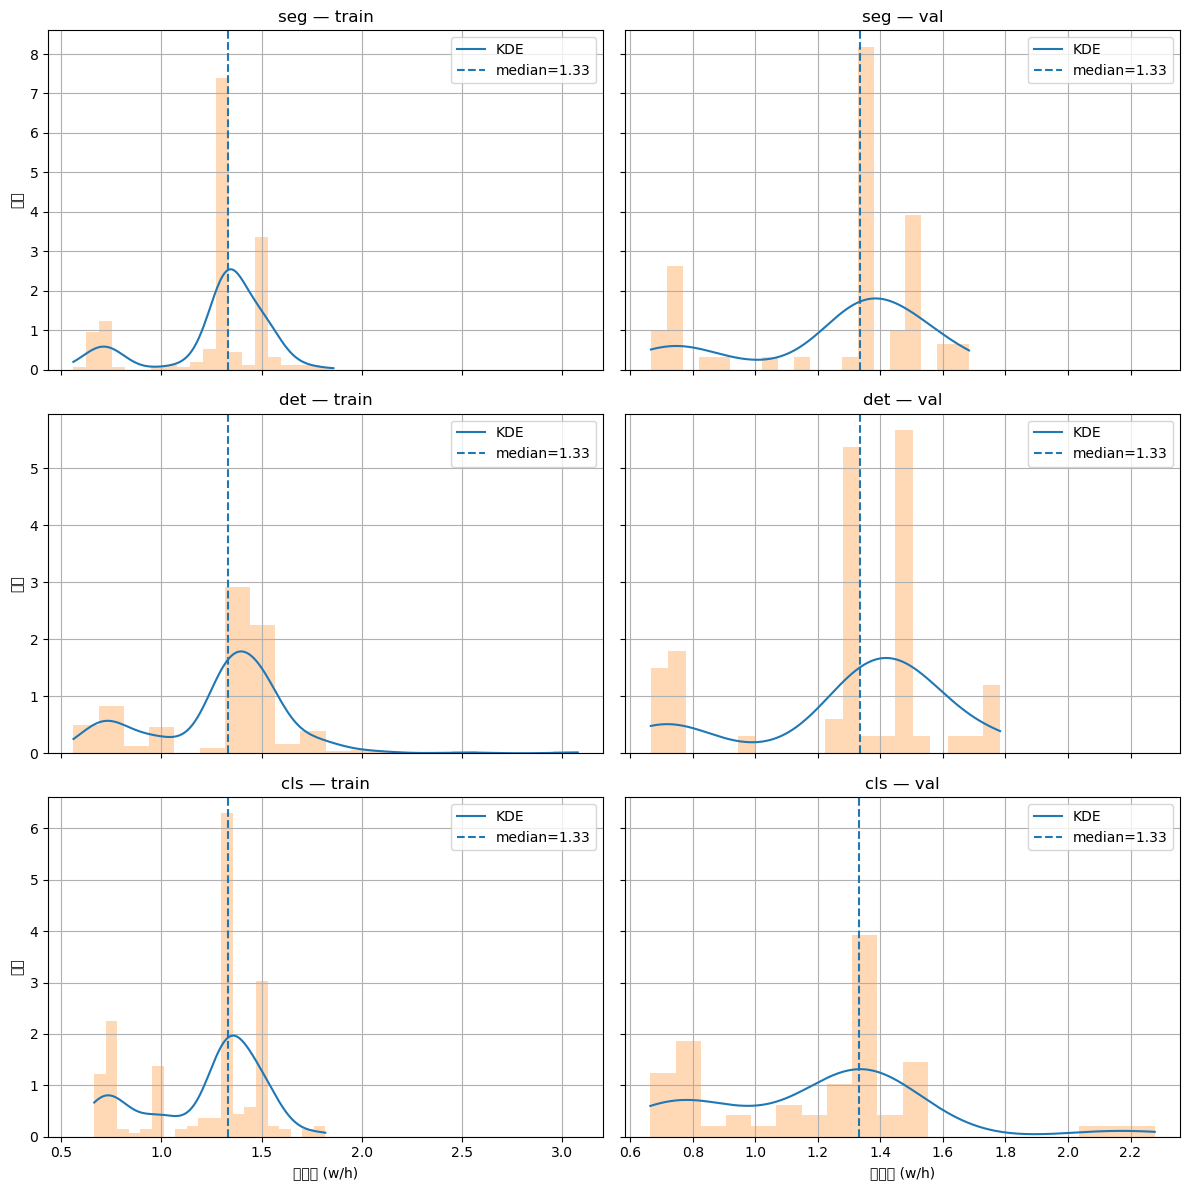

In [6]:
import numpy as np
from scipy.stats import gaussian_kde

tasks = ['seg', 'det', 'cls']
splits = ['train', 'val']
max_samples = 1000
batch_size = 16
num_workers = 0

fig, axs = plt.subplots(
    len(tasks), len(splits),
    figsize=(12, 12),
    sharex='col', sharey='row'
)

for i, task in enumerate(tasks):
    loaders = get_loaders(task, batch_size, num_workers, root_dir, torch.device("cuda"))
    for j, split in enumerate(splits):
        
        dataset = loaders[split].dataset
        widths, heights = [], []

        for idx, (img, _) in enumerate(dataset):
            if idx >= max_samples:
                break

            if isinstance(img, Image.Image):
                w, h = img.size
            elif isinstance(img, np.ndarray):
                h, w = img.shape[:2]
            else:  # torch.Tensor
                h, w = img.shape[1:3]

            widths.append(w)
            heights.append(h)

        ratios = np.array(widths) / np.array(heights)
        ax = axs[i, j]

        if len(ratios) > 1:
            kde = gaussian_kde(ratios)
            xi = np.linspace(ratios.min(), ratios.max(), 200)
            ax.plot(xi, kde(xi), label='KDE')
            ax.hist(ratios, bins=20, density=True, alpha=0.3)
            med = np.median(ratios)
            ax.axvline(med, linestyle='--', label=f'median={med:.2f}')

        ax.set_title(f'{task} — {split}')
        if i == len(tasks) - 1:
            ax.set_xlabel('宽高比 (w/h)')
        if j == 0:
            ax.set_ylabel('密度')
        ax.grid(True)
        ax.legend()

plt.tight_layout()
plt.show()

## 確認模型的架構

In [8]:
from scripts.models.DLHW2Net_v2 import DLHW2Net
print(DLHW2Net())

DLHW2Net(
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), str

## quick demo

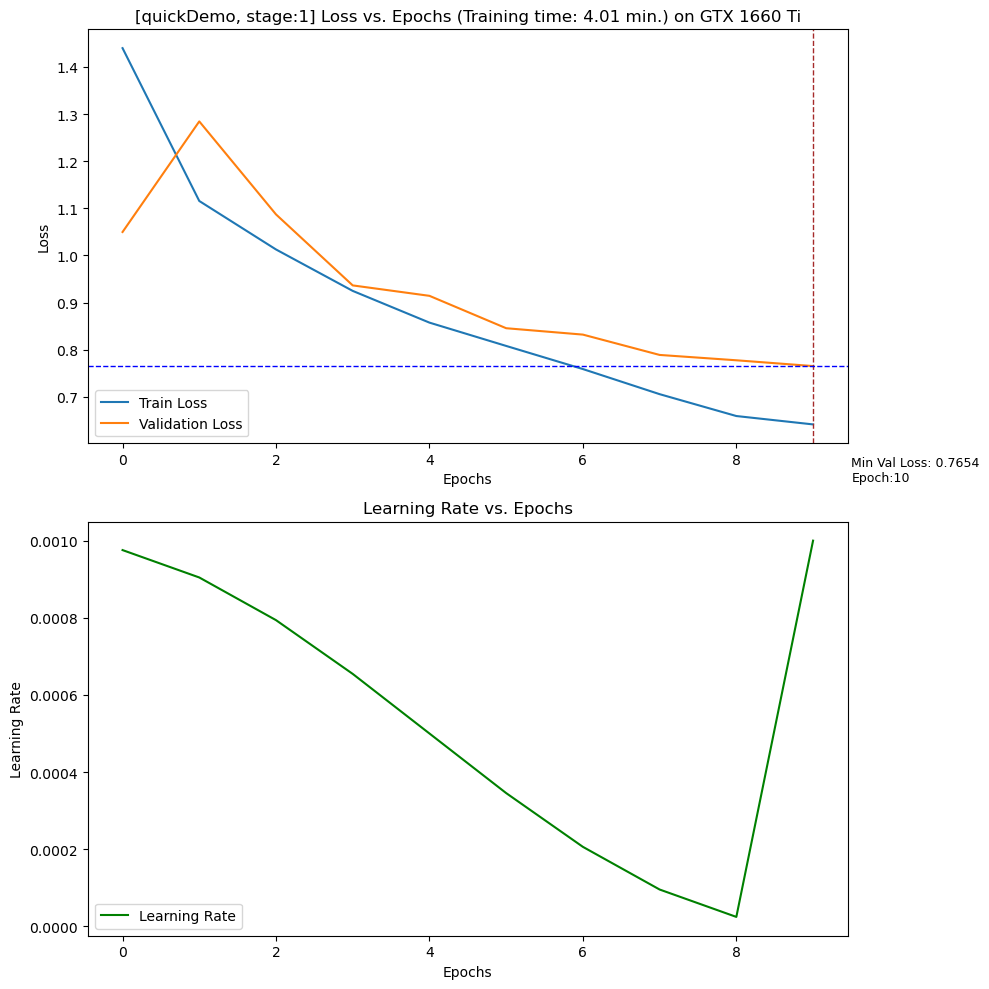

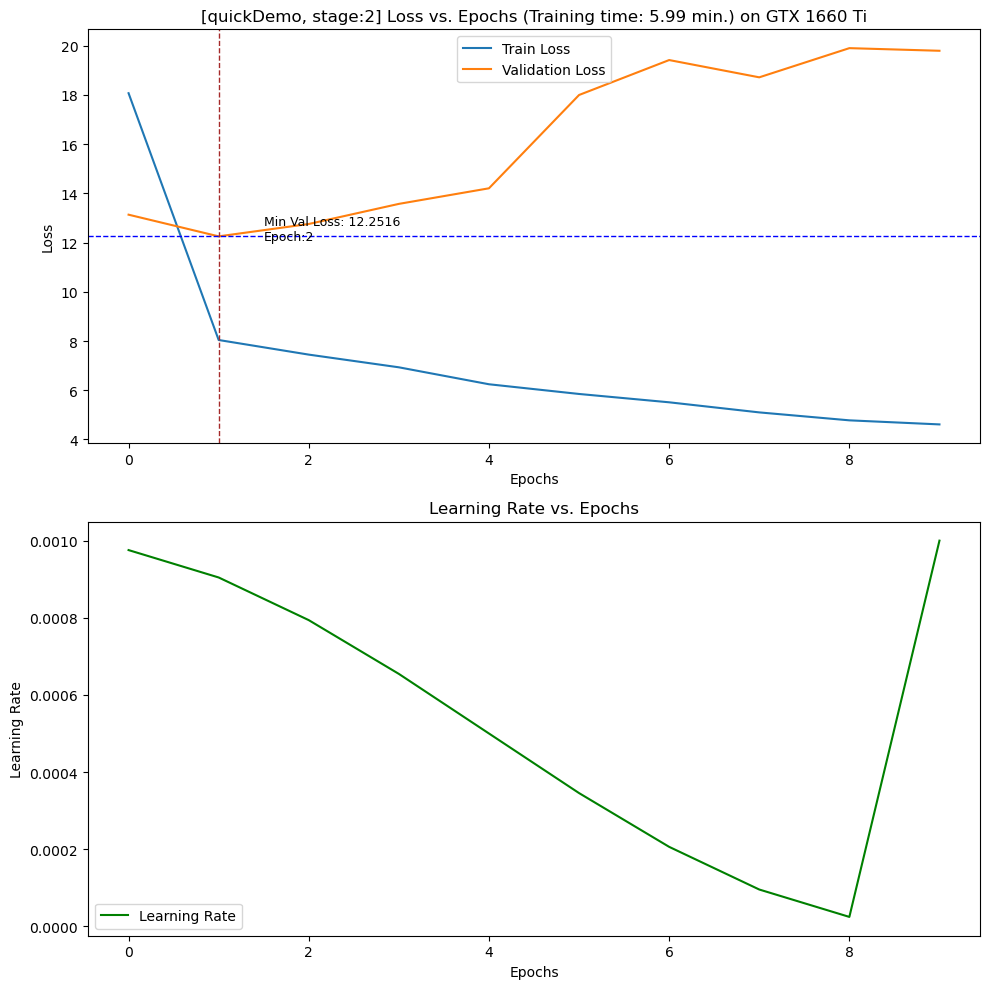

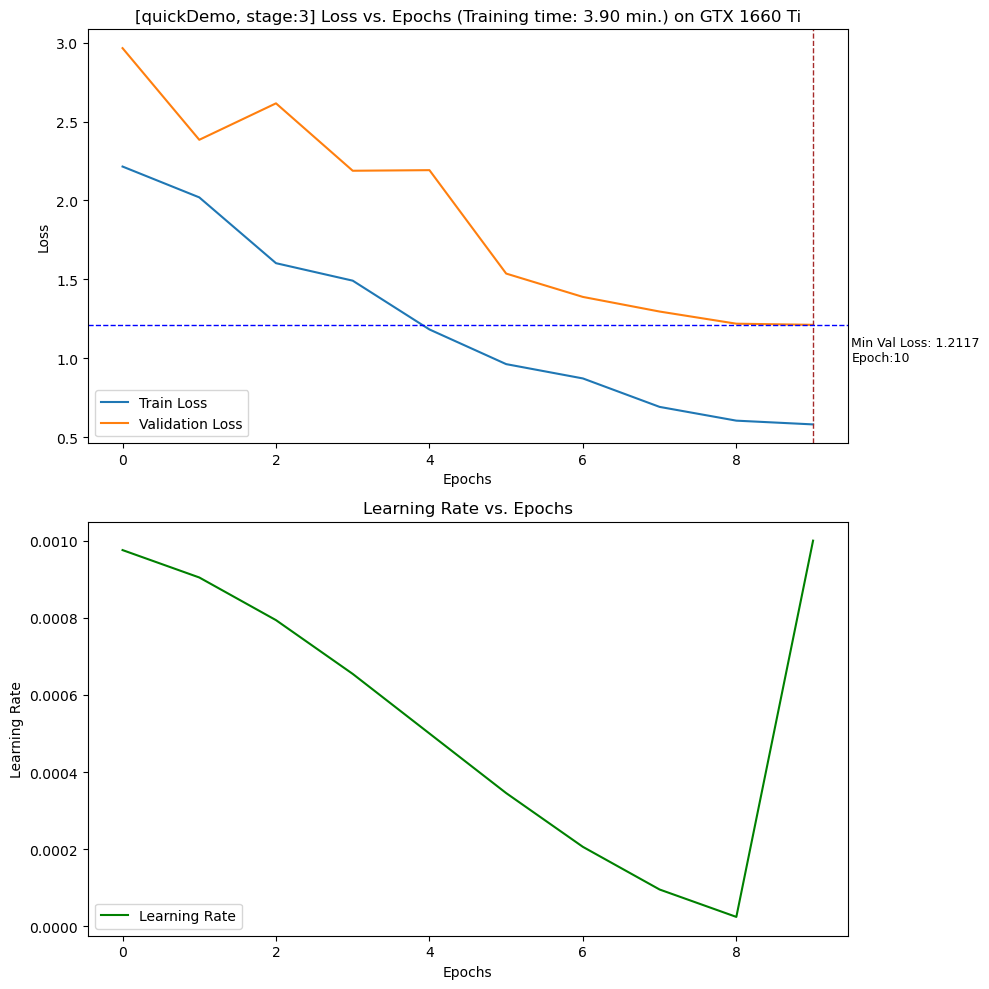

In [10]:
import json
for stage in range(1,4,1):
    with open(os.path.join(os.getcwd(),"scripts/models/trained", f"quickDemo_stage{stage}_log.json"), 'r') as log_file:
        log = json.load(log_file)

    min_val_loss = min(log['val_loss'])
    min_val_loss_epoch = log['val_loss'].index(min_val_loss)
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    # Plot train/val loss
    axs[0].set_title(f"[quickDemo, stage:{stage}] Loss vs. Epochs (Training time: {round(log['stage_time']/60, 2):.2f} min.) on GTX 1660 Ti")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].plot(log['train_loss'], label='Train Loss')
    axs[0].plot(log['val_loss'], label='Validation Loss')
    axs[0].axvline(x=min_val_loss_epoch, color='brown', linestyle='--', linewidth=1)
    axs[0].axhline(y=min_val_loss, color='blue', linestyle='--', linewidth=1)
    axs[0].text(min_val_loss_epoch+0.5, min_val_loss-0.25,
                f'Min Val Loss: {min_val_loss:.4f}\nEpoch:{min_val_loss_epoch + 1}',
                color='black', fontsize=9, ha='left', va='bottom')
    axs[0].legend()

    # Plot learning rate
    axs[1].set_title("Learning Rate vs. Epochs")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Learning Rate")
    axs[1].plot(log['lr'], label='Learning Rate', color='green')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [12]:
import os
import json
import pandas as pd
print(f"{'Stage':<6}{'Time(min)':>12}{'BestVal':>10}{'mIoU':>10}{'mAP':>10}{'Top-1':>10}")
print("-"*58)
for stage in range(1, 4):
    with open(f"scripts/models/trained/quickDemo_stage{stage}_log.json") as f:
        log = json.load(f)

    # 取值，None → float('nan')
    t    = log['stage_time']/60
    bv   = log['best_val_loss']
    miou = log.get('mIoU_base') or float('nan')
    mAP  = log.get('mAP_base')  or float('nan')
    t1   = log.get('Top1_base') or float('nan')

    print(f"{stage:<6}{t:>12.1f}{bv:>10.4f}{miou:>10.4f}{mAP:>10.4f}{t1:>10.4f}")

Stage    Time(min)   BestVal      mIoU       mAP     Top-1
----------------------------------------------------------
1              4.0    0.7654    0.1270       nan       nan
2              6.0   12.2516    0.1270       nan       nan
3              3.9    1.2117    0.1270       nan    0.6000


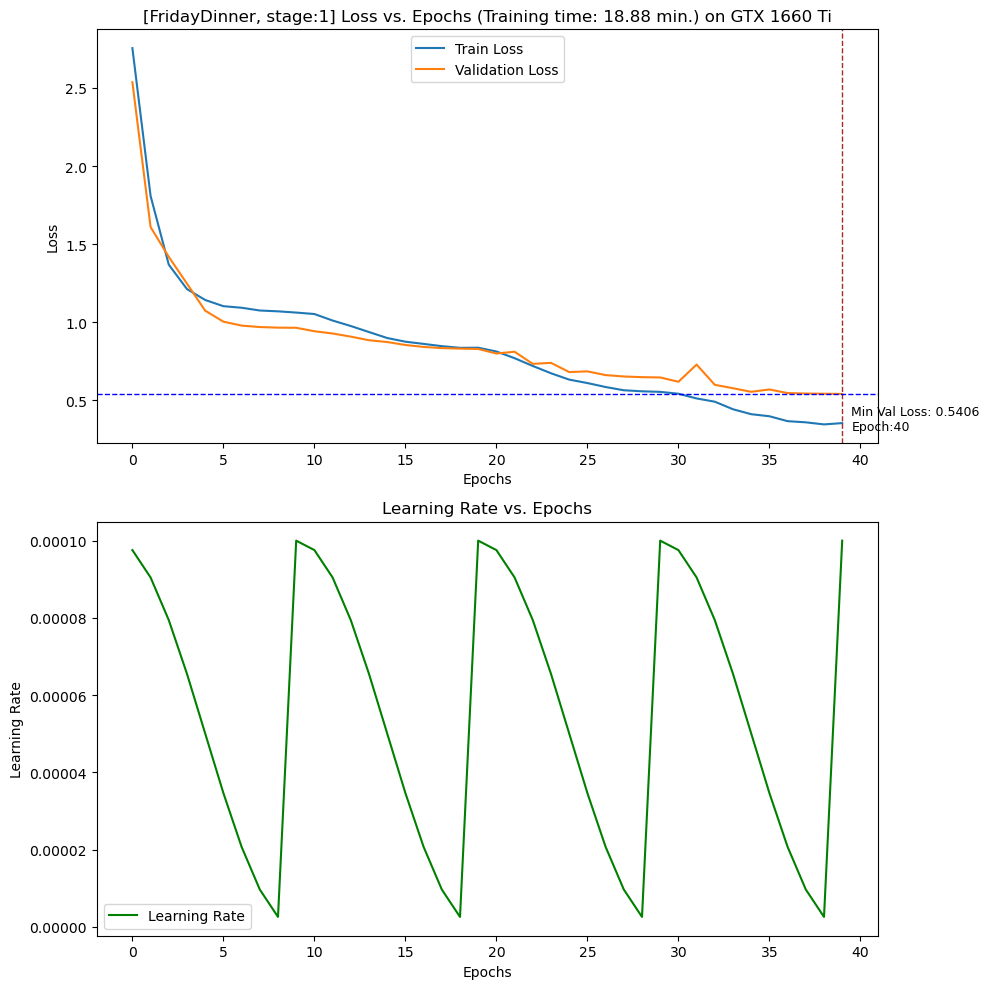

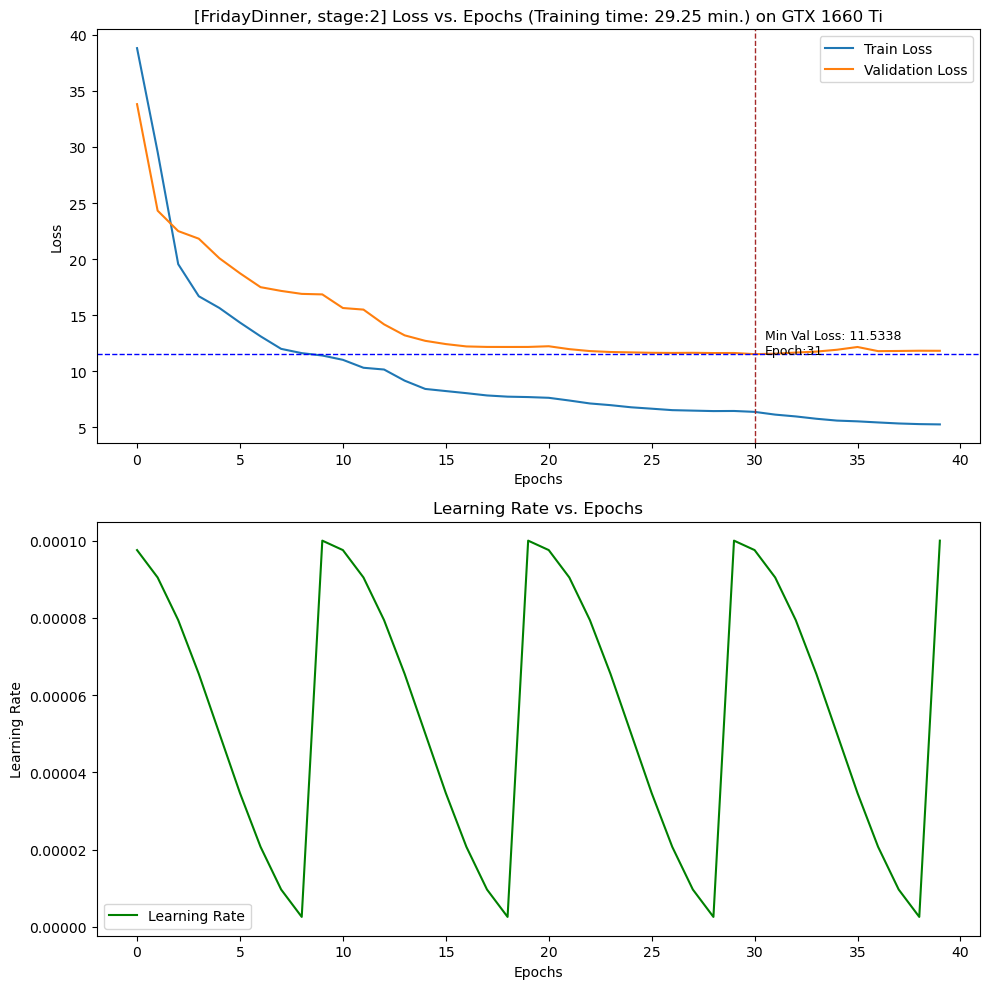

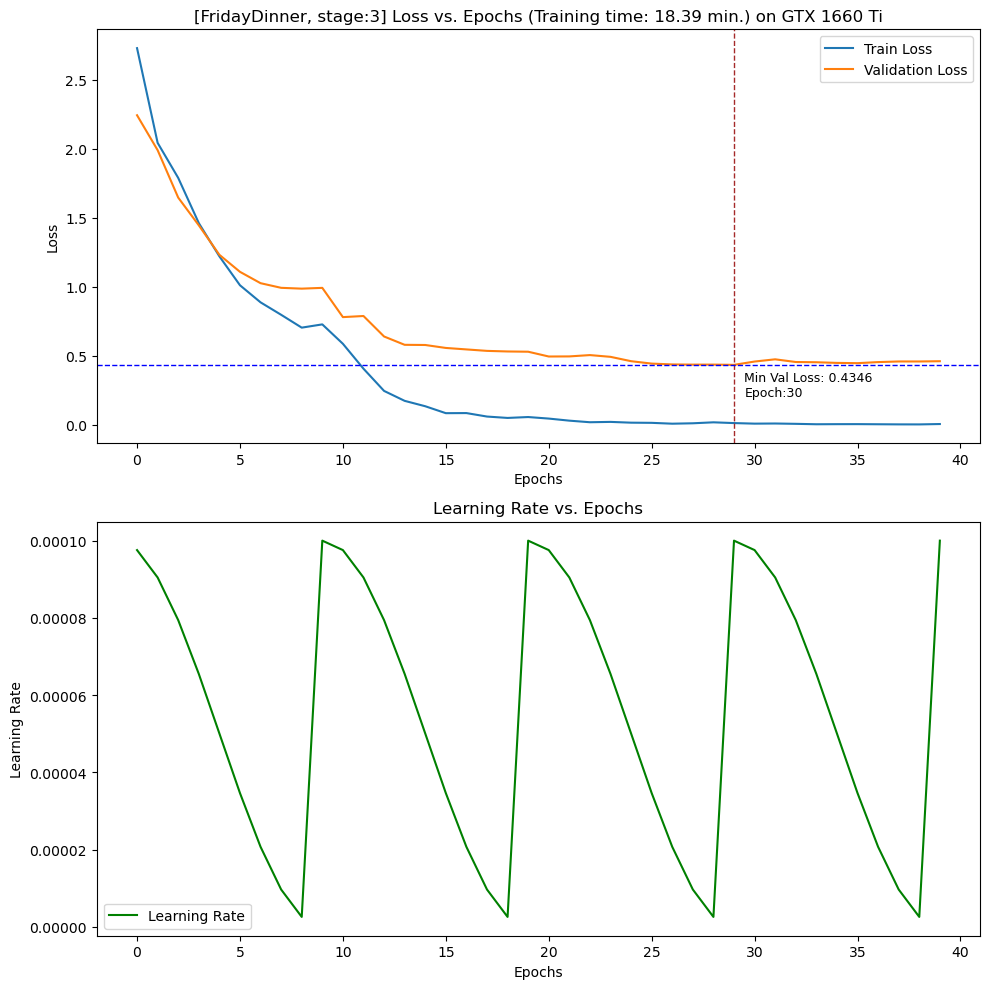

In [13]:
import json
for stage in range(1,4,1):
    with open(os.path.join(os.getcwd(),"scripts/models/trained", f"FridayDinner_stage{stage}_log.json"), 'r') as log_file:
        log = json.load(log_file)

    min_val_loss = min(log['val_loss'])
    min_val_loss_epoch = log['val_loss'].index(min_val_loss)
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    # Plot train/val loss
    axs[0].set_title(f"[FridayDinner, stage:{stage}] Loss vs. Epochs (Training time: {round(log['stage_time']/60, 2):.2f} min.) on GTX 1660 Ti")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].plot(log['train_loss'], label='Train Loss')
    axs[0].plot(log['val_loss'], label='Validation Loss')
    axs[0].axvline(x=min_val_loss_epoch, color='brown', linestyle='--', linewidth=1)
    axs[0].axhline(y=min_val_loss, color='blue', linestyle='--', linewidth=1)
    axs[0].text(min_val_loss_epoch+0.5, min_val_loss-0.25,
                f'Min Val Loss: {min_val_loss:.4f}\nEpoch:{min_val_loss_epoch + 1}',
                color='black', fontsize=9, ha='left', va='bottom')
    axs[0].legend()

    # Plot learning rate
    axs[1].set_title("Learning Rate vs. Epochs")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Learning Rate")
    axs[1].plot(log['lr'], label='Learning Rate', color='green')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [14]:
import os
import json
import pandas as pd
print(f"{'Stage':<6}{'Time(min)':>12}{'BestVal':>10}{'mIoU':>10}{'mAP':>10}{'Top-1':>10}")
print("-"*58)
for stage in range(1, 4):
    with open(f"scripts/models/trained/FridayDinner_stage{stage}_log.json") as f:
        log = json.load(f)

    # 取值，None → float('nan')
    t    = log['stage_time']/60
    bv   = log['best_val_loss']
    miou = log.get('mIoU_base') or float('nan')
    mAP  = log.get('mAP_base')  or float('nan')
    t1   = log.get('Top1_base') or float('nan')

    print(f"{stage:<6}{t:>12.1f}{bv:>10.4f}{miou:>10.4f}{mAP:>10.4f}{t1:>10.4f}")

Stage    Time(min)   BestVal      mIoU       mAP     Top-1
----------------------------------------------------------
1             18.9    0.5406    0.2464       nan       nan
2             29.2   11.5338    0.2464       nan       nan
3             18.4    0.4346    0.2464       nan    0.8500


## run a train.py

```bash
cd ~prject/scripts
conda activate d:/DL
python train.py --reco_code YourLabel --n_epoch 10 --n_workers 4 --batch_size 8 --init_lr 1e-3
```

## run eval.py

```bash
cd ~prject
conda activate d:/DL
python eval.py --weights scripts/models/trained/YourLabel_stage3_best.pth --data_root data --tasks all
```

The training employs :

1. cross-entropy loss for semantic segmentation

2. a combination of cross-entropy, Smooth L1, and binary cross-entropy losses for object detection

3. cross-entropy loss for image classification.

## Reference

1. E. Omar, J. Smith, K. Lee and Y. Zhang, “Loss Functions in Deep Learning: A Comprehensive Review,” Journal of Machine Learning Research, vol. 26, no. 3, pp. 123–167, Mar. 2025.